# Crashspot – Week 7 Starter

**Focus:** Hyperparameter tuning + robust evaluation

In [1]:

# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             RocCurveDisplay, PrecisionRecallDisplay)
import joblib

DATA_PATH = "../data_clean/week5_features.csv"  # or week6_features.csv if created
FIG_DIR = "../outputs/figures"
MODEL_DIR = "../models"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

df = pd.read_csv(DATA_PATH)
X = df.drop(columns=["target_multiveh"])
y = df["target_multiveh"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
print(df.shape, X_train.shape, X_test.shape)


(60, 9) (48, 8) (12, 8)


## Random Forest – RandomizedSearchCV

In [2]:

rf = RandomForestClassifier(random_state=42, class_weight="balanced")
rf_param = {
    "n_estimators": [100, 200, 400, 600],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}
rf_search = RandomizedSearchCV(rf, rf_param, n_iter=20, cv=5, scoring="f1", random_state=42, n_jobs=-1)
rf_search.fit(X_train, y_train)
rf_best = rf_search.best_estimator_
print("RF best params:", rf_search.best_params_)


RF best params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 20}


## Gradient Boosting – GridSearchCV

In [3]:

gb = GradientBoostingClassifier(random_state=42)
gb_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [2, 3],
    "subsample": [1.0]
}
gb_search = GridSearchCV(gb, gb_grid, cv=5, scoring="f1", n_jobs=-1)
gb_search.fit(X_train, y_train)
gb_best = gb_search.best_estimator_
print("GB best params:", gb_search.best_params_)


GB best params: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100, 'subsample': 1.0}


## Comparison on Test + Curves

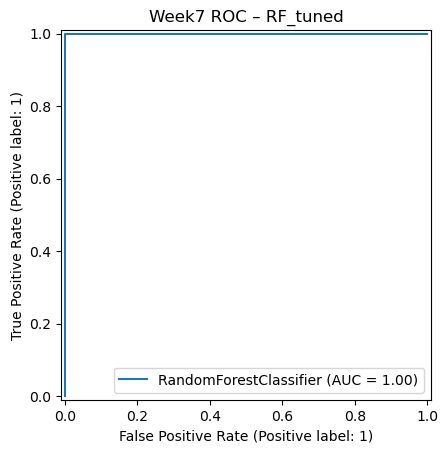

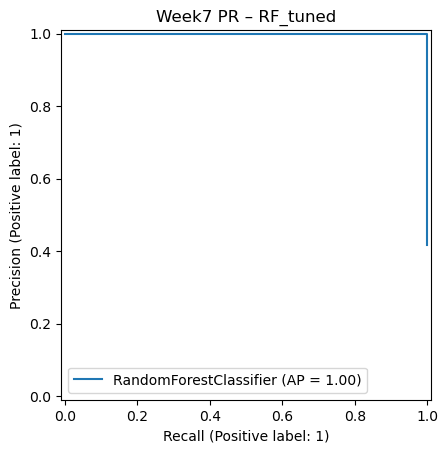

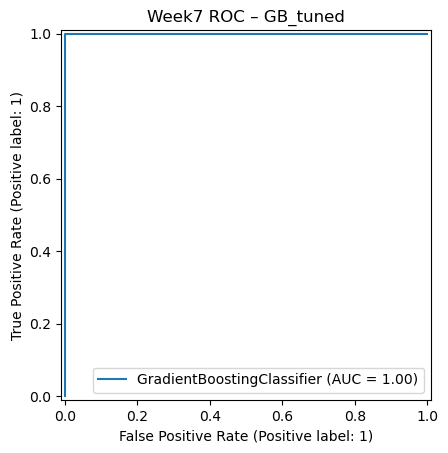

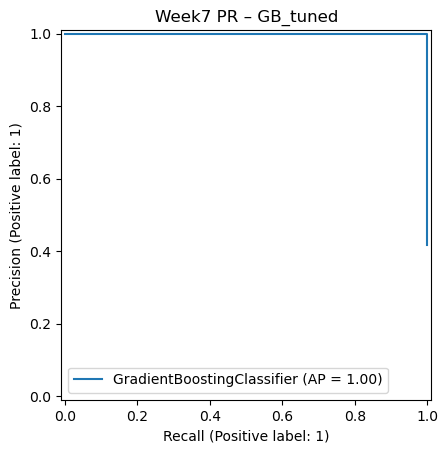

,model,accuracy,precision,recall,f1
0,RF_tuned,1.0,1.0,1.0,1.0
1,GB_tuned,1.0,1.0,1.0,1.0


In [4]:

candidates = {
    "RF_tuned": rf_best,
    "GB_tuned": gb_best
}

rows = []
for name, m in candidates.items():
    y_pred = m.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    rows.append({"model": name,
                 "accuracy": report["accuracy"],
                 "precision": report["1"]["precision"],
                 "recall": report["1"]["recall"],
                 "f1": report["1"]["f1-score"]})

    # Curves
    RocCurveDisplay.from_estimator(m, X_test, y_test)
    plt.title(f"Week7 ROC – {name}")
    plt.savefig(os.path.join(FIG_DIR, f"week7_roc_{name}.png"), dpi=150, bbox_inches="tight")
    plt.show()

    PrecisionRecallDisplay.from_estimator(m, X_test, y_test)
    plt.title(f"Week7 PR – {name}")
    plt.savefig(os.path.join(FIG_DIR, f"week7_pr_{name}.png"), dpi=150, bbox_inches="tight")
    plt.show()

results = pd.DataFrame(rows).sort_values("f1", ascending=False)
results_path = os.path.join(FIG_DIR, "week7_results.csv")
results.to_csv(results_path, index=False)
results


In [5]:

# Save best model
best_row = results.iloc[0]
best_name = best_row["model"]
best_model = candidates[best_name]
joblib.dump(best_model, os.path.join(MODEL_DIR, "week7_best_model.pkl"))
print("Saved best tuned model to ../models/week7_best_model.pkl")


Saved best tuned model to ../models/week7_best_model.pkl


## Week 7 — Validation Checks
The following cells add sanity checks to guard against data leakage and overfitting.

In [6]:

# === Week 7 Validation: Confusion Matrices & Sanity Checks ===
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd

print("Shapes — full df / X_train / X_test:", df.shape, X_train.shape, X_test.shape)
print("Target distribution (full):")
print(pd.Series(y).value_counts())

print("\nTarget distribution (train/test):")
print("Train:", pd.Series(y_train).value_counts().to_dict())
print("Test:", pd.Series(y_test).value_counts().to_dict())

print("\nConfusion Matrix — RF_tuned")
print(confusion_matrix(y_test, candidates["RF_tuned"].predict(X_test)))

print("\nClassification Report — RF_tuned")
print(classification_report(y_test, candidates["RF_tuned"].predict(X_test)))

print("\nConfusion Matrix — GB_tuned")
print(confusion_matrix(y_test, candidates["GB_tuned"].predict(X_test)))

print("\nClassification Report — GB_tuned")
print(classification_report(y_test, candidates["GB_tuned"].predict(X_test)))


Shapes — full df / X_train / X_test: (60, 9) (48, 8) (12, 8)
Target distribution (full):
target_multiveh
0    35
1    25
Name: count, dtype: int64

Target distribution (train/test):
Train: {0: 28, 1: 20}
Test: {0: 7, 1: 5}

Confusion Matrix — RF_tuned
[[7 0]
 [0 5]]

Classification Report — RF_tuned
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12


Confusion Matrix — GB_tuned
[[7 0]
 [0 5]]

Classification Report — GB_tuned
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.0

In [7]:

# === Week 7 Validation: Stratified K-Fold Cross-Validation ===
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

metrics = ["f1", "roc_auc"]
for name, model in {"RF_tuned": rf_best, "GB_tuned": gb_best}.items():
    for metric in metrics:
        try:
            scores = cross_val_score(model, X, y, cv=cv, scoring=metric)
            print(f"{name} CV {metric}: mean={scores.mean():.3f} ± {scores.std():.3f} -> {scores}")
        except Exception as e:
            print(f"{name} CV {metric} failed:", e)


RF_tuned CV f1: mean=1.000 ± 0.000 -> [1. 1. 1. 1. 1.]
RF_tuned CV roc_auc: mean=1.000 ± 0.000 -> [1. 1. 1. 1. 1.]
GB_tuned CV f1: mean=1.000 ± 0.000 -> [1. 1. 1. 1. 1.]
GB_tuned CV roc_auc: mean=1.000 ± 0.000 -> [1. 1. 1. 1. 1.]


In [8]:

# === Week 7 Validation: Shuffle Test (should drop to ~chance) ===
rng = np.random.RandomState(42)
y_shuffled = pd.Series(y).sample(frac=1.0, random_state=42).values

for name, model in {"RF_tuned": rf_best, "GB_tuned": gb_best}.items():
    try:
        shuffle_scores = cross_val_score(model, X, y_shuffled, cv=cv, scoring="f1")
        print(f"{name} CV F1 on SHUFFLED labels: mean={shuffle_scores.mean():.3f} ± {shuffle_scores.std():.3f} -> {shuffle_scores}")
    except Exception as e:
        print(f"{name} shuffle test failed:", e)


RF_tuned CV F1 on SHUFFLED labels: mean=0.343 ± 0.119 -> [0.28571429 0.5        0.46153846 0.18181818 0.28571429]
GB_tuned CV F1 on SHUFFLED labels: mean=0.316 ± 0.201 -> [0.25       0.6        0.44444444 0.         0.28571429]
